In [1]:
import sys
sys.path.insert(1, '/home/msantolaria/Documents/MyPythonLibrary/ClimAnag/libhma/')
import climbasis as climb
from climbasis import *
import domain as dom
import myplot
import glob
from eofs.xarray import Eof
import obsinfo as obs
from myplot import *
import obsinfo as obs
from obsinfo import *
import matplotlib.path as mpath



source='/home/msantolaria/Documents/MyResearch/GabiSAM/UBSam/'
#resultsDir=source + 'Results/'
#plotsDir='/home/msantolaria/Documents/MyResearch/MassBalanceSAM/OutputSeptiembre2022/'
plotsDir='/home/msantolaria/Documents/MyResearch/MassBalanceSAM/OutputApril2024/'

#resultsDir='/media/maria/MARIAEXT2/WinterTrendsObs/'
sourceData='/home/msantolaria/Documents/Data/'

/home/msantolaria/anaconda3/envs/cartoenv/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/msantolaria/anaconda3/envs/cartoenv/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
iyr=1980
fyr=2014
mapa=True

domain='SHWest'
variable='t850'
units='K'
model=str('eraint')
fileName ='t850_mon_eraint_1979-2015.nc'
ds = xr.open_dataset(sourceData+model+'/'+fileName)['t']

ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180))
ds = ds.roll(longitude=int(len(ds['longitude']) / 2), roll_coords=True)
#field=dom.field_dom(ds,domain)

lat,lon=climb.latlon(ds)
ylat=ds.coords['latitude']
xlon=ds.coords['longitude']

field=ds.sel(latitude=slice(-20,-90),longitude=slice(-170,-10))
#latS,latN,lonW,lonE,latlim,lonlim=dom.coord_domain(domain)
#field=dom.field_sel_dom(ds,domain)
print(ds.units)

K


In [3]:
ds.longitude

<xarray.DataArray 'longitude' (longitude: 480)> Size: 2kB
array([-180.  , -179.25, -178.5 , ...,  177.75,  178.5 ,  179.25],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 2kB -180.0 -179.2 -178.5 ... 178.5 179.2

In [4]:
# Opening files
variable2='wind'
data2='eraint'
#filenameu = sourceData+'u925.mon.eraint_197901_201512.nc'
#filenamev = sourceData+'v925.mon.eraint_197901_201512.nc'
filenameu = sourceData+model+'/'+'u850.mon_eraint_1979-2015.nc'
filenamev= sourceData+model+'/'+'v850.mon_eraint_1979-2015.nc'

dsu0 = xr.open_dataset(filenameu)['u']
dsu0 = dsu0.assign_coords(longitude=(((dsu0.longitude + 180) % 360) - 180))
dsu = dsu0.roll(longitude=int(len(dsu0['longitude']) / 2), roll_coords=True)

dsv0 = xr.open_dataset(filenamev)['v']
dsv0 = dsv0.assign_coords(longitude=(((dsv0.longitude + 180) % 360) - 180))
dsv = dsv0.roll(longitude=int(len(dsv0['longitude']) / 2), roll_coords=True)

unitsw=dsv.units
lat,lon=climb.latlon(dsu)
ylat=dsu.coords['latitude']
xlon=dsu.coords['longitude']

fieldu=dsu.sel(latitude=slice(-20,-90),longitude=slice(-170,-10))
fieldv=dsv.sel(latitude=slice(-20,-90),longitude=slice(-170,-10))

In [5]:
rList=[]
rList_ma=[]
pList=[]
index_name='GabiSAM'
#Regression
sourceIndex='/home/msantolaria/Documents/MyResearch/MassBalanceSAM/UBSam/Index/'
mode='SAM'
seasons=['DJF','MAM','JJA','SON']
for season in seasons:
    if season=='DJF':
        indexName=mode+'_'+season+'_19791980_20132014.txt'
        index=np.loadtxt(sourceIndex+indexName)
        print(indexName)
        print(index.shape)
        vals,anoms=climb.seasonal_selection(field,season,iyr-1,fyr-1)
        anoms_detrend=climb.detrend_dim(vals, 'time', deg=1)
    else:
        indexName=mode+'_'+season+'_1980_2014.txt'
        index=np.loadtxt(sourceIndex+indexName)
        print(indexName)
        print(index.shape)
        vals,anoms=climb.seasonal_selection(field,season,iyr,fyr)
        anoms_detrend=climb.detrend_dim(vals, 'time', deg=1)
    par=climb.trend_vect(index,anoms,'time')
    #trend=par[0]
    #intercept=par[1]
    rvalue=par[2]
    pvalue=par[3]
    #stderr=par[4]
    rvalue_ma=np.where(pvalue>0.1,np.nan,rvalue) 
    rList_ma.append(rvalue_ma)
    rList.append(rvalue)
    pList.append(pvalue)

SAM_DJF_19791980_20132014.txt
(35,)
(D- 1979  JF- 1980  to D- 2013 JF- 2014
trend-0 intercept-1 rvalue-2 pvalue-3 stderr-4
SAM_MAM_1980_2014.txt
(35,)
trend-0 intercept-1 rvalue-2 pvalue-3 stderr-4
SAM_JJA_1980_2014.txt
(35,)
trend-0 intercept-1 rvalue-2 pvalue-3 stderr-4
SAM_SON_1980_2014.txt
(35,)
trend-0 intercept-1 rvalue-2 pvalue-3 stderr-4


In [6]:
clevs=[-1., -0.9,-0.8,-0.7, -0.6,-0.5,-0.4 ,-0.3,-0.2 ,-0.1,0.1, 0.2 , 0.3,
  0.4 , 0.5,0.6  , 0.7,0.8 , 0.9,1. ]
assert len(clevs) % 2 == 0, 'N levels must be even.'
cmap = mcolors.LinearSegmentedColormap.from_list(name='red_white_blue', 
                                                 colors =[(0, 0, 1), 
                                                          (1, 1., 1), 
                                                          (1, 0, 0)],
                                                 N=len(clevs)-1,
                                                 )
#levs_ticks=[-1., -0.8, -0.6,-0.4 ,-0.2 , 0.2 , 
#  0.4 , 0.6  , 0.8 , 1. ]
levs_ticks=[-.9, -0.7, -0.5,-0.3 ,-0.1 , 0.1 , 
  0.3 , 0.5  , 0.7 , 0.9 ]    

/home/msantolaria/anaconda3/envs/cartoenv/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/msantolaria/anaconda3/envs/cartoenv/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/msantolaria/anaconda3/envs/cartoenv/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


/home/msantolaria/Documents/MyResearch/MassBalanceSAM/OutputApril2024/spa_cor_t850_eraint_GabiSAM_seasons_SHWest_1980-2014_MSO_rev2_onlysig


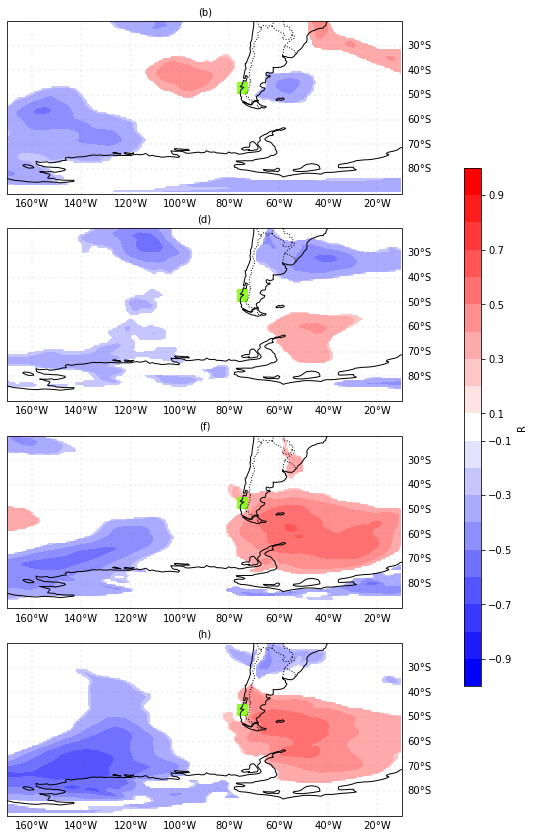

In [7]:
latS,latN,lonW,lonE,latlim,lonlim=dom.coord_domain(domain)
nrows=4
ncols=1
#clevs=np.arange(-1.0,1.1,0.1)
#color='PiYG'
#cmap='bwr'
exp='obs'
decomp='original'
titleList=['(b)','(d)','(f)','(h)']
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree()},figsize=(12,24))
axs=axs.flatten()
#Loop over all of the models
for i in np.arange(0,len(rList),1):
        lat,lon=climb.latlon(rList[i])
        lons, lats = np.meshgrid(rList[i][lon],rList[i][lat])
        # Contour plot
        CS1=axs[i].contourf(lons, lats, rList_ma[i],clevs,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap)
        #CS1=axs[i].contourf(lons, lats, rList[i].where(pList[i] <0.1),clevs,
      #              transform=ccrs.PlateCarree(),
      #              cmap=cmap)
        levels=[0,0.1,1.0]
 #       cs = axs[i].contourf(lons,lats,pList[i][:,:], transform=ccrs.PlateCarree(),levels=levels,
 #               hatches=["\\\\", ""], alpha=0.)
        # Title each subplot with the name of the model
#        axs[i].text(-0.1, 0.5, seasons[i],
  #      verticalalignment='center', horizontalalignment='left',
 #       transform=axs[i].transAxes,
  #      color='black', fontsize=12)
        gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=2, color='gray', alpha=0.1, linestyle=':')
        gl.xlabels_top = False
        gl.ylabels_right = True
        gl.ylabels_left = False
        gl.set_ylocator=mticker.FixedLocator(np.arange(latS,latN,15),0)
        gl.set_xlocator = mticker.FixedLocator(np.arange(lonW,lonE,10),0)
        gl.set_xformatter = LongitudeFormatter
        gl.set_yformatter = LatitudeFormatter
        gl.set_xlabel_style = {'color': 'black'}
        gl.set_xlabel_style = {'color': 'black'}
        geom = geometry.box(minx=-77,maxx=-73,miny=-44.7,maxy=-49.3)
        axs[i].add_geometries([geom], facecolor='chartreuse',edgecolor='chartreuse',crs=ccrs.PlateCarree(), alpha=0.8)
        # Draw the coastines for each subplot
        axs[i].coastlines()
        axs[i].set_title(titleList[i],fontsize=10)
        axs[i].add_feature(cfeature.BORDERS, linestyle=':', alpha=1)
        axs[i].add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='none'))
        axs[i].set_extent([lonW, lonE, latS,latN])
    # Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.20, top=0.66, left=0.25, right=0.75,
                    wspace=0.0000000005, hspace=0.20)

#plt.tight_layout()
#cax=fig.add_axes([left,bottom,width,height]
#cbar_ax = fig.add_axes([0.2, 0.15, 0.6, 0.02])
#cbar=fig.colorbar(CS1,cax=cbar_ax,orientation='horizontal',label='%s'%(units))
cbar_ax = fig.add_axes([0.80, 0.275, 0.020, 0.3])#[gauche, bas, largeur, hauteur] 
cbar=fig.colorbar(CS1,cax=cbar_ax,ticks=levs_ticks,orientation='vertical',label='R')
#plt.suptitle('(b)',y=0.67)
plotname='spa_cor_%s_%s_%s_seasons_%s_%i-%i_MSO_rev2_onlysig'%(variable,model,index_name,domain,iyr,fyr)
plt.savefig(plotsDir+plotname+'.png',format='png')
print(plotsDir+plotname)
plt.show()

In [8]:
#-----------------------------------------
ruList=[];ruList_ma=[]
puList=[]
rvList=[];rvList_ma=[]
pvList=[]
pwList=[]
climu=[]
climv=[]
#Regression
sourceIndex='/home/msantolaria/Documents/MyResearch/MassBalanceSAM/UBSam/Index/'
mode='SAM'
seasons=['DJF','MAM','JJA','SON']
for season in seasons:
    if season=='DJF':
        indexName=mode+'_'+season+'_19791980_20132014.txt'
        index=np.loadtxt(sourceIndex+indexName)
        print(indexName)
        print(index.shape)
        valsu,anomsu=climb.seasonal_selection(fieldu,season,iyr-1,fyr-1)
        #anomsu_detrend=climb.detrend_dim(valsu, 'time', deg=1)
        valsv,anomsv=climb.seasonal_selection(fieldv,season,iyr-1,fyr-1)
        #anomsv_detrend=climb.detrend_dim(valsv, 'time', deg=1)
        tmp=valsu.mean('time')
        tmp1=valsv.mean('time')
    else:
        indexName=mode+'_'+season+'_1980_2014.txt'
        index=np.loadtxt(sourceIndex+indexName)
        print(indexName)
        print(index.shape)
        valsu,anomsu=climb.seasonal_selection(fieldu,season,iyr,fyr)
        #anomsu_detrend=climb.detrend_dim(valsu, 'time', deg=1)
        valsv,anomsv=climb.seasonal_selection(fieldv,season,iyr,fyr)
        #anomsv_detrend=climb.detrend_dim(valsv, 'time', deg=1)
        tmp=valsu.mean('time')
        tmp1=valsv.mean('time')

    paru=climb.trend_vect(index,anomsu,'time')
    #trend=par[0]
    #intercept=par[1]
    ruvalue=paru[0]
    puvalue=paru[3]
    #stderr=par[4]
    ruList.append(ruvalue)
    puList.append(puvalue)
    parv=climb.trend_vect(index,anomsv,'time')
    #trend=par[0]
    #intercept=par[1]
    rvvalue=parv[0]
    pvvalue=parv[3]
    #stderr=par[4]
    rvList.append(rvvalue)
    pvList.append(pvvalue)  
    #pw=np.where(pvvalue>puvalue,puvalue,pvvalue) #take the lowest p-value of both u,v    
    ruvalue_ma=np.where(puvalue>0.1,np.nan,ruvalue) 
    #rvvalue_ma=np.where(puvalue>0.1,np.nan,rvvalue) 
    ruList_ma.append(ruvalue_ma)
    climu.append(tmp)
    climv.append(tmp1)
    #rvList_ma.append(rvvalue_ma)
    #pwList.append(pw)

SAM_DJF_19791980_20132014.txt
(35,)
(D- 1979  JF- 1980  to D- 2013 JF- 2014
(D- 1979  JF- 1980  to D- 2013 JF- 2014
trend-0 intercept-1 rvalue-2 pvalue-3 stderr-4
trend-0 intercept-1 rvalue-2 pvalue-3 stderr-4
SAM_MAM_1980_2014.txt
(35,)
trend-0 intercept-1 rvalue-2 pvalue-3 stderr-4
trend-0 intercept-1 rvalue-2 pvalue-3 stderr-4
SAM_JJA_1980_2014.txt
(35,)
trend-0 intercept-1 rvalue-2 pvalue-3 stderr-4
trend-0 intercept-1 rvalue-2 pvalue-3 stderr-4
SAM_SON_1980_2014.txt
(35,)
trend-0 intercept-1 rvalue-2 pvalue-3 stderr-4
trend-0 intercept-1 rvalue-2 pvalue-3 stderr-4


/home/msantolaria/anaconda3/envs/cartoenv/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/msantolaria/anaconda3/envs/cartoenv/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/msantolaria/anaconda3/envs/cartoenv/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


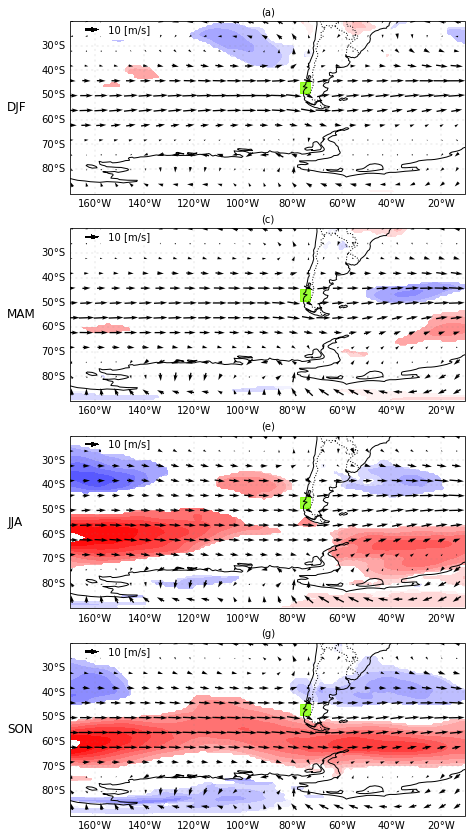

In [9]:
titleList=['(a)','(c)','(e)','(g)']
latS,latN,lonW,lonE,latlim,lonlim=dom.coord_domain(domain)
nrows=4
ncols=1
clevs=np.arange(-1.0,1.1,0.1)
#color='PiYG'
cmap='bwr'
exp='obs'
decomp='original'
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree()},figsize=(12,24))
axs=axs.flatten()

for i in np.arange(0,len(ruList),1):
    lons, lats = np.meshgrid(ruList[i][lon],ruList[i][lat])

        # Contour plot
    CS1=axs[i].contourf(lons, lats, ruList_ma[i],clevs,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap)
    delta=8
 # Add arrows to show the wind vectors
    Q1=axs[i].quiver(lons[::delta,::delta],lats[::delta,::delta],climu[i][::delta,::delta],climv[i][::delta,::delta],pivot='middle', 
                     transform=ccrs.PlateCarree(),
        angles="xy",
        scale_units="xy",
        scale=2,color='black',
        #minshaft=4,
       # minlength=0.1,
       # width=0.1
             )
    #Q1=axs[i].quiver(lons,lats, ruList[i][:,:], rvList[i][:,:], pivot='middle', 
   #                  transform=ccrs.PlateCarree(),
   #     angles="xy",
    #    scale_units="xy",
   #     scale=0.25,color='black',
        #minshaft=4,
       # minlength=0.1,
       # width=0.1
   #          )
# Normalise the data for uniform arrow size
#u_norm = u / np.sqrt(u ** 2.0 + v ** 2.0)
#v_norm = v / np.sqrt(u ** 2.0 + v ** 2.0)
#plt.quiver(x, y, u_norm, v_norm, pivot='middle', transform=transform)
#plt.quiverkey(Q1, 1.2, 0.515, 2, 'arrow 1', coordinates='data')
    qk=axs[i].quiverkey(Q1,                      #Incoming quiver handle
              X=0.07, Y = 0.95,       #Determine the location of label, all limited to [0,1]
              U = 10,                   #Reference arrow length means the wind speed is 5m/s.
             angle = 0,            #Reference arrow placement angle. The default is 0,
             label=' 10 [m/s]',        #Arrow's supplement: label's content + 
             labelpos='E',          #label is in which direction of the reference arrow; S means south
             color = 'black',labelcolor = 'black',fontproperties={'size': '10'})
    t = qk.text.set_backgroundcolor('white')
    levels=[0,0.1,1.0]
   # cs = axs[i].contourf(lons,lats,puList[i][:,:], transform=ccrs.PlateCarree(),levels=levels,
    #             hatches=["\\\\", ""], alpha=0.)
        # Title each subplot with the name of the model
    axs[i].text(-0.16, 0.5, seasons[i],
    verticalalignment='center', horizontalalignment='left',
    transform=axs[i].transAxes,
    color='black', fontsize=12)
    geom = geometry.box(minx=-77,maxx=-73,miny=-44.7,maxy=-49.3)
    axs[i].add_geometries([geom], facecolor='chartreuse',edgecolor='chartreuse',crs=ccrs.PlateCarree(), alpha=0.8)
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
      linewidth=2, color='gray', alpha=0.1, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylabels_left = True
    gl.set_ylocator=mticker.FixedLocator(np.arange(latS,latN,15),0)
    gl.set_xlocator = mticker.FixedLocator(np.arange(lonW,lonE,10),0)
    gl.set_xformatter = LongitudeFormatter
    gl.set_yformatter = LatitudeFormatter
    gl.set_xlabel_style = {'color': 'black'}
    gl.set_xlabel_style = {'color': 'black'}
    # Draw the coastines for each subplot
    axs[i].coastlines()
    axs[i].set_title(titleList[i],fontsize=10)
    axs[i].add_feature(cfeature.BORDERS, linestyle=':', alpha=1)
    axs[i].add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='none'))
    axs[i].set_extent([lonW, lonE, latS,latN])
    # Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.20, top=0.66, left=0.25, right=0.75,
                    wspace=0.0000000005, hspace=0.20)
    # Add a colorbar axis at the bottom of the graph
    #([xmin,ymin,dx,dy])
#cbar_ax = fig.add_axes([0.2, 0.3, 0.6, 0.02])
    # Draw the colorbar
#cbar=fig.colorbar(CS1, cax=cbar_ax,orientation='horizontal',label='%s'%(units))
    ## Add a big title at the top
    #plt.suptitle('%s'%(seasons[i]),y=0.73)
#plt.suptitle('(a)',y=0.67)
plotname='spa_cor_%s_%s_%s_seasons_%s_%i-%i_MSO_rev2_onlysig'%('wind850',model,index_name,domain,iyr,fyr)
plt.savefig(plotsDir+plotname+'.png',format='png')
plt.show()
